### Association Rules

In [1]:
!pip install apyori

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=6015 sha256=512f5ec698d3523b26db7fa67ea5d87b0d103579f9af15cfe932dbd06c2ae89e
  Stored in directory: a:\wpsystem\s-1-5-21-910491398-3542826876-2768250131-1001\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local\pip\cache\wheels\77\3d\a6\d317a6fb32be58a602b1e8c6b5d6f31f79322da554cad2a5ea
Successfully built apyori


In [7]:
import pandas as pd
from apyori import apriori
import numpy as np
# Load dataset
df = pd.read_csv('Groceries_dataset.csv', header=0)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


In [ ]:
df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [12]:
#checking for missing values
df.isnull().sum()

Member_number      0
Date               0
itemDescription    0
dtype: int64

In [ ]:
#clearing column names
df.columns = df.columns.str.strip()
#altering date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Member_number,Date,itemDescription
0,1808,2015-07-21,tropical fruit
1,2552,2015-01-05,whole milk
2,2300,2015-09-19,pip fruit
3,1187,2015-12-12,other vegetables
4,3037,2015-02-01,whole milk


In [16]:
#integrating transactions per date
df['TransactionID'] = df['Member_number'].astype(str) + '_' + df['Date'].dt.strftime('%Y-%m-%d')
df.head()

,Member_number,Date,itemDescription,TransactionID
0,1808,2015-07-21,tropical fruit,1808_2015-07-21
1,2552,2015-01-05,whole milk,2552_2015-01-05
2,2300,2015-09-19,pip fruit,2300_2015-09-19
3,1187,2015-12-12,other vegetables,1187_2015-12-12
4,3037,2015-02-01,whole milk,3037_2015-02-01


Baseline basket length: {'m_transactions': 14963, 'len_mean': 2.590723785337165, 'len_median': 2.0, 'len_q10': 2.0, 'len_q90': 4.0}
Baseline top-10 item relative freq:
 itemDescription
whole milk          0.167212
other vegetables    0.126846
rolls/buns          0.114683
soda                0.101183
yogurt              0.089153
root vegetables     0.071577
tropical fruit      0.068970
bottled water       0.062354
sausage             0.061752
citrus fruit        0.054267
Name: count, dtype: float64


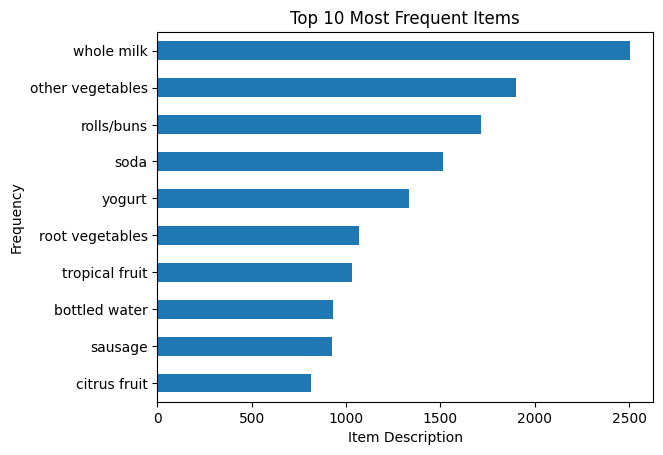

In [25]:
lens = df.groupby('TransactionID')['itemDescription'].count()
base_stats = {
    'm_transactions': lens.shape[0],
    'len_mean': float(lens.mean()),
    'len_median': float(lens.median()),
    'len_q10': float(lens.quantile(0.10)),
    'len_q90': float(lens.quantile(0.90)),
}
print("Baseline basket length:", base_stats)

top_counts = df['itemDescription'].value_counts()
top_rel = (top_counts / lens.shape[0]).head(10)
print("Baseline top-10 item relative freq:\n", top_rel)
#graphing top 10 items
import matplotlib.pyplot as plt
top_counts.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.ylabel('Frequency')
plt.xlabel('Item Description')
plt.title('Top 10 Most Frequent Items')
plt.show()

Now we have preprocessed the data into one-hot encoded dataset, which is suitable for association mining. 

In [27]:
#splitting dataset into 6 chunks
TARGET_M_LIST = [500, 1000, 2000, 5000, 10000, 20000]  # 按你数据量/电脑性能调整
RNG = np.random.default_rng(42)

#transactionIDs
all_transaction_ids = basket_df['TransactionID'].unique()
len_transactions = len(all_transaction_ids)
print(f"Total unique transactions: {len_transactions}")

Total unique transactions: 14963


In [29]:
subsets = {}

for m in TARGET_M_LIST:
    m_eff = min(m, len(all_transaction_ids))  
    chosen = RNG.choice(all_transaction_ids, size=m_eff, replace=False)
    chosen = set(chosen)

    # sampling from original detailed df
    df_sub = df[df['TransactionID'].isin(chosen)].copy()

    # if backet_df exists, use it to get wide format
    if 'basket_df' in globals():
        basket_sub = basket_df[basket_df['TransactionID'].isin(chosen)].copy()
    else:
        # else recreate wide format from df_sub
        basket_sub = (
            df_sub.groupby('TransactionID')['itemDescription']
                  .apply(lambda s: ','.join(sorted(s.unique())))
                  .reset_index()
                  .rename(columns={'itemDescription':'Items'})
        )

    subsets[m] = {'tall': df_sub, 'wide': basket_sub}

    print(f"[m={m_eff}] tall={len(df_sub):>7}, number of transactions={df_sub['TransactionID'].nunique():>6}")


[m=500] tall=   1337, number of transactions=   500
[m=1000] tall=   2689, number of transactions=  1000
[m=2000] tall=   5176, number of transactions=  2000
[m=5000] tall=  12819, number of transactions=  5000
[m=10000] tall=  25842, number of transactions= 10000
[m=14963] tall=  38765, number of transactions= 14963
